In [1]:
import math
import numpy as np
import ceo
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
N = 401
L = 25.0
tid = ceo.StopWatch()
delta = L/(N-1)
print(delta)

0.0625


## Single layer single source

In [9]:
atm = ceo.Atmosphere(15e-2,30,N_LAYER=1,altitude=[0e3],xi0=[1.0],
                     wind_speed=[10.0],wind_direction=[0],
                     L=L,NXY_PUPIL=N,fov=60.0*ceo.constants.ARCSEC2RAD,duration=30,filename='singleLayer.bin')

In [10]:
src =ceo.Source('R',resolution=(N,N))

In [11]:
tel = ceo.Mask(N*N)
src.masked(tel)

In [12]:
tau = 0.0
src.reset()
tid.tic()
atm.get_phase_screen(src,delta,N,delta,N,tau)
tid.toc()
print("ET=%.4fms"%tid.elapsedTime)
print(src.wavefront.rms(-6))
ps1 = src.phase.host(units='micron')

ET=188.4303ms
[1.73558976]


In [13]:
tau = 0.0
src.reset()
tid.tic()
atm.ray_tracing(src,delta,N,delta,N,tau)
tid.toc()
print ("ET=%.4fms"%tid.elapsedTime)
print (src.wavefront.rms(-6))
ps2 = src.phase.host(units='micron')

ET=0.1004ms
[1.73558976]


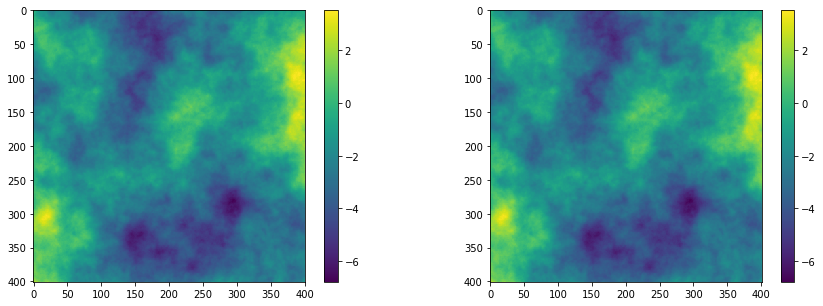

In [14]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(15,5)
h1 = ax1.imshow(ps1)
plt.colorbar(h1,ax=ax1)
h2 = ax2.imshow(ps2)
plt.colorbar(h2,ax=ax2)

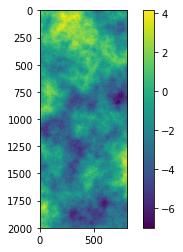

In [15]:
layer_phase_screen = atm.layers[0].phase_screen.host(units='micron')[-2000:,:]*atm.r0**(-5/6)
plt.imshow(layer_phase_screen)
plt.colorbar()

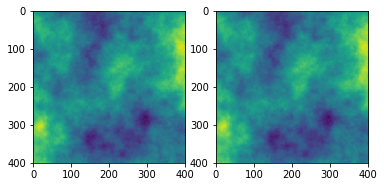

In [16]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
ax1.imshow(ps1,vmin=layer_phase_screen.min(),vmax=layer_phase_screen.max())
ax2.imshow(ps2,vmin=layer_phase_screen.min(),vmax=layer_phase_screen.max())

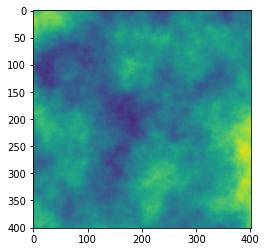

In [17]:
src.reset()
tid.tic()
atm.ray_tracing(src,delta,N,delta,N,1.0)
tid.toc()
ps = src.phase.host(units='micron')
plt.imshow(ps,vmin=layer_phase_screen.min(),vmax=layer_phase_screen.max())

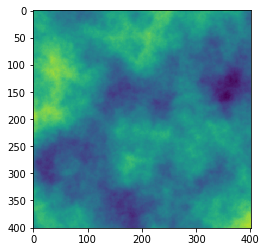

In [18]:
src.reset()
tid.tic()
atm.ray_tracing(src,delta,N,delta,N,2.1)
tid.toc()
ps = src.phase.host(units='micron')
plt.imshow(ps,vmin=layer_phase_screen.min(),vmax=layer_phase_screen.max())

In [19]:
nTau = 300
wfe_rms = np.zeros((2,nTau))
tid = ceo.StopWatch()
tid.tic()
for k in range(nTau):
    tau = k*1e-2
    src.reset()
    atm.get_phase_screen(src,delta,N,delta,N,tau)
    wfe_rms[0,k] = src.wavefront.rms(-6)
    src.reset()
    atm.ray_tracing(src,delta,N,delta,N,tau)
    wfe_rms[1,k] = src.wavefront.rms(-6)
tid.toc()
print("ET: %.2fs"%(1e-3*tid.elapsedTime))

ET: 57.45s


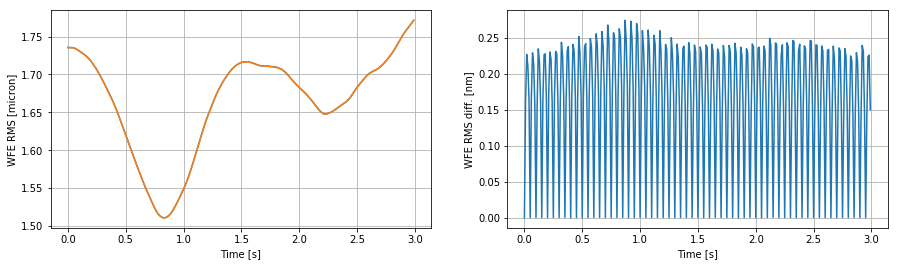

In [20]:
t = np.arange(nTau)*1e-2
fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(15,4)
ax1.plot(t,wfe_rms.T)
ax1.grid()
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('WFE RMS [micron]')
ax2.plot(t,1e3*(wfe_rms[0,:]-wfe_rms[1,:]))
ax2.grid()
ax2.set_xlabel('Time [s]')
ax2.set_ylabel('WFE RMS diff. [nm]');

## Single layer @10km three sources

In [52]:
atm = ceo.Atmosphere(15e-2,30,N_LAYER=1,altitude=[10e3],xi0=[1.0],
                     wind_speed=[10.0],wind_direction=[0*math.pi/4],
                     L=L,NXY_PUPIL=N,fov=6*ceo.constants.ARCMIN2RAD,
                     filename='threeLayers.bin',N_DURATION=30)

In [53]:
src =ceo.Source('R',zenith=np.ones(3)*2.5*ceo.constants.ARCMIN2RAD,
                azimuth=np.arange(3)*2*math.pi/3,resolution=(N,N))
#src =ceo.Source('R',zenith=np.ones(3)*0.5*ceo.constants.ARCMIN2RAD,azimuth=[0,0,0],resolution=(N,N))
tel = ceo.Mask(N*N*src.N_SRC)
src.masked(tel)

In [54]:
tau = 0.0
src.reset()
tid.tic()
atm.get_phase_screen(src,delta,N,delta,N,tau)
tid.toc()
print( "ET=%.4fms"%tid.elapsedTime)
ps1 = src.phase.host(units='micron')
src.wavefront.rms(-6)

ET=591.1050ms


array([1.73439446, 1.97689792, 1.57642648])

In [55]:
src.reset()
tid.tic()
atm.ray_tracing(src,delta,N,delta,N,tau)
tid.toc()
print( "ET=%.4fms"%tid.elapsedTime)
ps2 = src.phase.host(units='micron')
src.wavefront.rms(-6)

ET=0.2683ms


array([1.73400292, 1.97677355, 1.57627107])

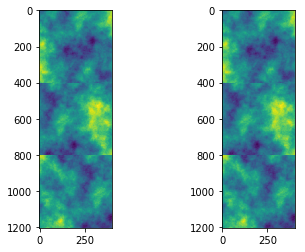

In [56]:
fig,(ax1,ax2) = plt.subplots(nrows=1,ncols=2)
ax1.imshow(ps1)
ax2.imshow(ps2)

In [57]:
nTau = 300
wfe_rms = np.zeros((src.N_SRC,nTau))
for k in range(nTau):
    tau = k*1e-2
    src.reset()
    atm.ray_tracing(src,delta,N,delta,N,tau)
    wfe_rms[:,k] = src.wavefront.rms(-6)

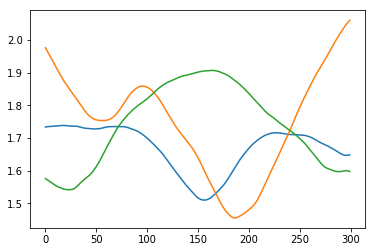

In [58]:
plt.plot(wfe_rms.T)

In [59]:
xc = np.ravel(10e3*src.zenith*np.cos(src.azimuth))
yc = np.ravel(10e3*src.zenith*np.sin(src.azimuth))
x0 = -L/2+xc
y0 = -L/2+yc
tau = 0
print( atm.layers[0].WIDTH)
layer_phase_screen = atm.layers[0].phase_screen.host(units='micron')*atm.r0**(-5/6)

42.46875


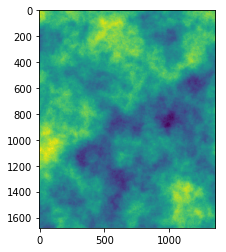

In [60]:
plt.imshow(layer_phase_screen)

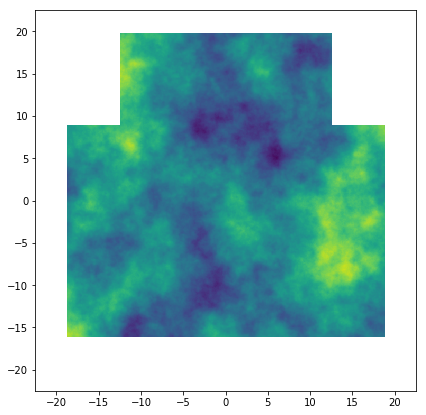

In [65]:
src.reset()
atm.ray_tracing(src,delta,N,delta,N,tau)
ps = src.phase.host(units='micron')
fig,ax = plt.subplots()
fig.set_size_inches(7,7)
vmin,vmax = layer_phase_screen.min(),layer_phase_screen.max()
for k in range(src.N_SRC):
    e = [yc[k]-L/2,yc[k]+L/2,xc[k]+L/2,xc[k]-L/2]
    ax.imshow(ps[k*N:(k+1)*N,:],extent=e,vmin=vmin,vmax=vmax)
lim = np.array([-L,L])*0.9
ax.set_xlim(lim)
ax.set_ylim(lim);

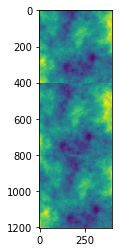

In [50]:
plt.imshow(ps)

## Two layers three sources¶

In [16]:
atm = ceo.Atmosphere(15e-2,30,N_LAYER=2,altitude=[0,10e3],xi0=[0.7,0.3],
                     wind_speed=[10.0,20.0],wind_direction=[0,4*math.pi/3],
                     L=L,NXY_PUPIL=N,fov=60.0*2*ceo.constants.ARCSEC2RAD)

In [18]:
tau = 0.0
src.reset()
tid.tic()
atm.get_phase_screen(src,delta,N,delta,N,tau)
tid.toc()
print( "ET=%.4fms"%tid.elapsedTime)
src.wavefront.rms(-6)

ET=1169.2124ms


array([1.41432804, 1.3798915 , 1.54151235])

In [19]:
tau = 0.0
src.reset()
tid.tic()
atm.ray_tracing(src,delta,N,delta,N,tau)
tid.toc()
print( "ET=%.4fms"%tid.elapsedTime)
src.wavefront.rms(-6)

ET=0.3994ms


array([1.79345989, 1.76171648, 1.78670268])

In [25]:
nTau = 300
wfe_rms = np.zeros((src.N_SRC,nTau))
for k in range(nTau):
    tau = k*1e-2
    src.reset()
    atm.ray_tracing(src,delta,N,delta,N,tau)
    wfe_rms[:,k] = src.wavefront.rms(-6)

In [26]:
traces = []
for k in range(src.N_SRC):
    traces.append( go.Trace(y=wfe_rms[k,:],name='Ray tracing #%d'%k) )
iplot(go.Data(traces))

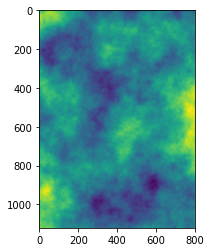

In [22]:
layer_phase_screen = atm.layers[0].phase_screen.host(units='micron')
plt.imshow(layer_phase_screen)

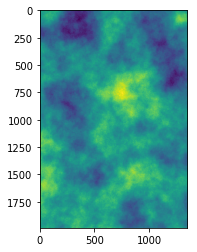

In [23]:
layer_phase_screen = atm.layers[1].phase_screen.host(units='micron')
plt.imshow(layer_phase_screen)

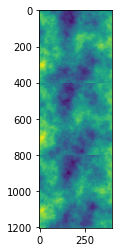

In [24]:
src.reset()
atm.ray_tracing(src,delta,N,delta,N,tau)
ps = src.phase.host(units='micron')
plt.imshow(ps)

## GMT atmosphere

In [3]:
atm= ceo.GmtAtmosphere(15e-2,30,L=L,NXY_PUPIL=N,fov=2*ceo.constants.ARCMIN2RAD,
                       duration=30)#,filename='/home/ubuntu/phaseScreens.bin')

KeyboardInterrupt: 

In [27]:
nTau = 3000
wfe_rms = np.zeros((src.N_SRC,nTau))
tid.tic()
for k in range(nTau):
    tau = k*1e-2
    src.reset()
    atm.ray_tracing(src,delta,N,delta,N,tau)
    wfe_rms[:,k] = src.wavefront.rms(-6)
tid.toc()
print("ET=%.4fms"%tid.elapsedTime)

ET=6218.5557ms


In [20]:
traces = []
for k in range(src.N_SRC):
    traces.append( go.Trace(y=wfe_rms[k,:],name='Ray tracing #%d'%k) )
iplot(go.Data(traces))

In [29]:
print( "Theoretical rms : %.2fmicron"%(np.sqrt(ceo.phaseStats.variance(atmosphere=atm))*550e-3*0.5/math.pi))
print( "Experimental rms: %.2fmicron"%np.sqrt(np.mean(wfe_rms**2)))

Theoretical rms : 2.13micron
Experimental rms: 1.87micron


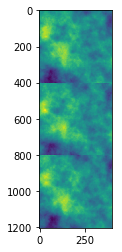

In [30]:
src.reset()
atm.ray_tracing(src,delta,N,delta,N,tau)
ps = src.phase.host(units='micron')
plt.imshow(ps)